## Imports

In [1]:
import sys
from pathlib import Path
PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))

# basics
import pandas as pd
import json
import joblib

# feature_importance
import shap

# models
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    train_test_split
)

# utils
import os
from ppm.nodes.metrics_calculator import (
    metrics_calculate,
    show_results
)
from ppm.nodes.cross_validation import (
    cross_validation
)
from ppm.nodes.process_outputs import (
    ranking_output
)
from ppm.nodes.feature_explainer import (
    tree_explainer,
    shap_explainer
)
from ppm.nodes.plots import (
    plot_feature_importance,
    plot_predictions,
    plot_true_vs_pred,
    plot_true_vs_pred_multiple
)
from ppm.nodes.outliers_detection import (
    detect_outliers
)

/home/manuel/.cache/pypoetry/virtualenvs/property-price-modelling-UIhV6JXy-py3.10/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/manuel/.cache/pypoetry/virtualenvs/property-price-modelling-UIhV6JXy-py3.10/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.htm

## Parameters

In [2]:
path_root = os.path.join("..","oos")
path_root_data = os.path.join("..", "data")
path_primary = os.path.join(
    path_root, "03_primary"
)
path_primary_data = os.path.join(
    path_root_data, "03_primary"
)
path_model = os.path.join(
    path_root_data, "04_model"
)
path_encoders = os.path.join(
    path_model, "encoders"
)
path_model_final = os.path.join(
    path_model, "model"
)

file_path_metrics_features_test = os.path.join(
    path_primary_data, "features_test_metrics.json"
)
file_path_metrics_features_selected = os.path.join(
    path_primary_data, "features_selected.json"
)
file_path_best_params = os.path.join(
    path_model, "best_params.json"
)
file_path_encoder_order = os.path.join(
    path_encoders, "encoders_orders.csv"
)
file_path_data_input = os.path.join(
    path_primary, "data_input.csv" 
)
file_path_not_outliers = os.path.join(
    path_primary_data, "data_not_outliers.csv"
)

In [71]:
n_samples_oos = -1
price_cutoff = 2*10**(100)# (6)

## Read content

In [87]:
data_input = pd.read_csv(
    file_path_not_outliers, # file_path_data_input, file_path_not_outliers
    index_col = 0
)

In [88]:
encoders_order = pd.read_csv(
    file_path_encoder_order
)

In [89]:
# read encoders
encoders = {}
for encoder_content in encoders_order.values:
    encoder_name, encoder_url = encoder_content
    encoders[encoder_name.split(".")[0]] = joblib.load(
        encoder_url
    )

In [90]:
# read model pycaret
model = {}
for model_name in os.listdir(path_model_final):
    model[model_name.split(".")[0]] = joblib.load(
        os.path.join(
            path_model_final,
            model_name
        )
    )

In [91]:
if os.path.exists(file_path_metrics_features_selected):
    with open(file_path_metrics_features_selected, 'r') as json_file:
        features_selected = json.load(json_file)
    features_selected = features_selected["selected_features"]

In [92]:
if os.path.exists(file_path_best_params):
    with open(file_path_best_params, 'r') as json_file:
        best_params = json.load(json_file)
    best_params = best_params["params"]
else:
    best_params = {
        "random_state": 42
    }

In [93]:
estimator = model["actual_estimator"]

In [94]:
target = [
    "price"
]
cd_setor_drop = [
    "cd_setor",
]
id_drop = [
    "ID"
]

In [95]:
data_input = data_input[data_input[target].values < price_cutoff].reset_index(drop = True)
data_input = data_input.head(n_samples_oos).copy()

In [96]:
data_input = data_input[id_drop + cd_setor_drop + target + features_selected].copy()

In [97]:
X = data_input.drop(
    cd_setor_drop + target,
    axis = 1
).copy()
y = data_input[id_drop + target].copy()

## Encoders process

In [98]:
encoded_data = {
    "oos": X.copy()
}
for encoder_name, encoder_content in encoders.items():
    print("--- encoder: [{}]".format(encoder_name))
    for type_name, data_to_encoder in encoded_data.items():
        id_row = data_to_encoder[id_drop[0]].values
        data_to_encoder.drop(id_drop[0], axis = 1, inplace = True)
        encoded_data[type_name] = encoder_content.transform(data_to_encoder)
        encoded_data[type_name].insert(0, id_drop[0], id_row)

--- encoder: [numerical_imputer]
--- encoder: [categorical_imputer]
--- encoder: [clean_column_names]


In [99]:
X_encoded = encoded_data['oos'].drop(id_drop, axis = 1).copy()

## Metrics

In [100]:
y_oos_preds = estimator.predict(X_encoded)

In [101]:
args_oos = [
    y[target[0]].values,
    y_oos_preds
]

metrics_oos = metrics_calculate(args_oos)

metrics_oos = show_results(metrics_oos, "oos")
metrics_results = metrics_oos

-------- [ oos ] ----------
r2 : 0.9432
mape : 0.0897
rmse : 53502.0207
mse : 2862466214.0353
mae : 35175.0925
median_ae : 21099.8939
correlation : 0.9733
size : 1853


In [102]:
data_values = {}
for name, args in zip(['oos'], [args_oos]):
    content = ranking_output(args)
    data_values[name] = content

In [103]:
data_values['oos'].filter(regex = r"y_*").corr()

,y_true,y_pred
y_true,1.000000,0.973305
y_pred,0.973305,1.000000


In [104]:
data_values['oos'].filter(regex = r"rank_*").corr()

,rank_true,rank_pred
rank_true,1.000000,0.973445
rank_pred,0.973445,1.000000


## Feature importances

In [105]:
feature_importances, features_selected = tree_explainer(
    model = [estimator],
    features_names = list(X_encoded.columns),
    n_features = 10
)

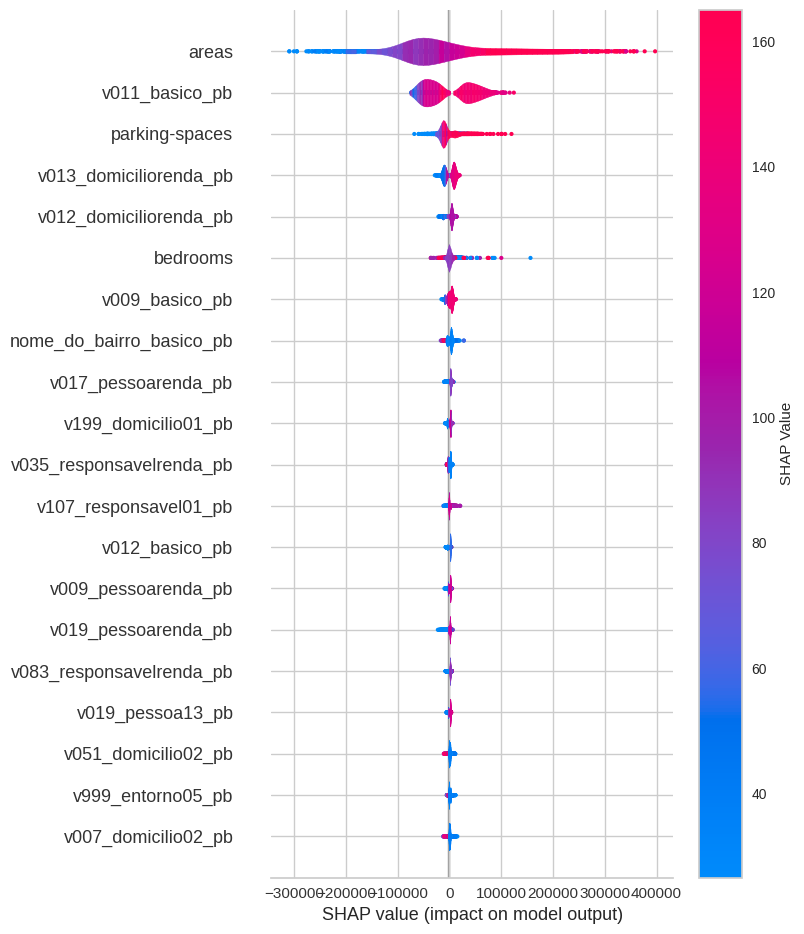

In [106]:
fig_shap, explainer = shap_explainer(
    [estimator],
    X_encoded
)

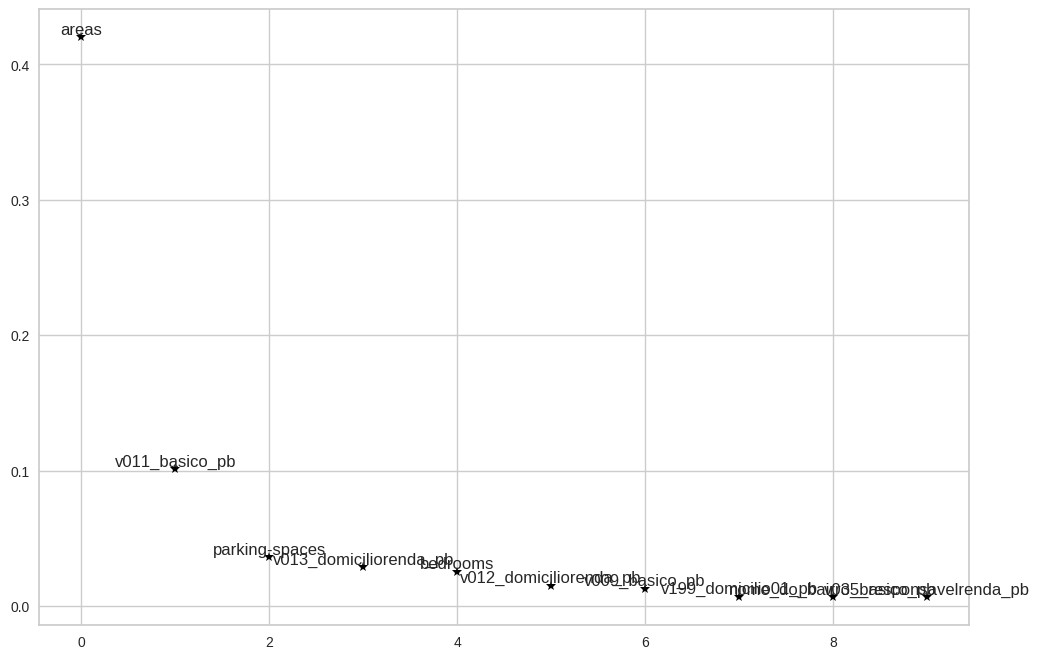

In [107]:
fig_tree_explainer = plot_feature_importance(
    feature_importances, 
    10
)

## Plots

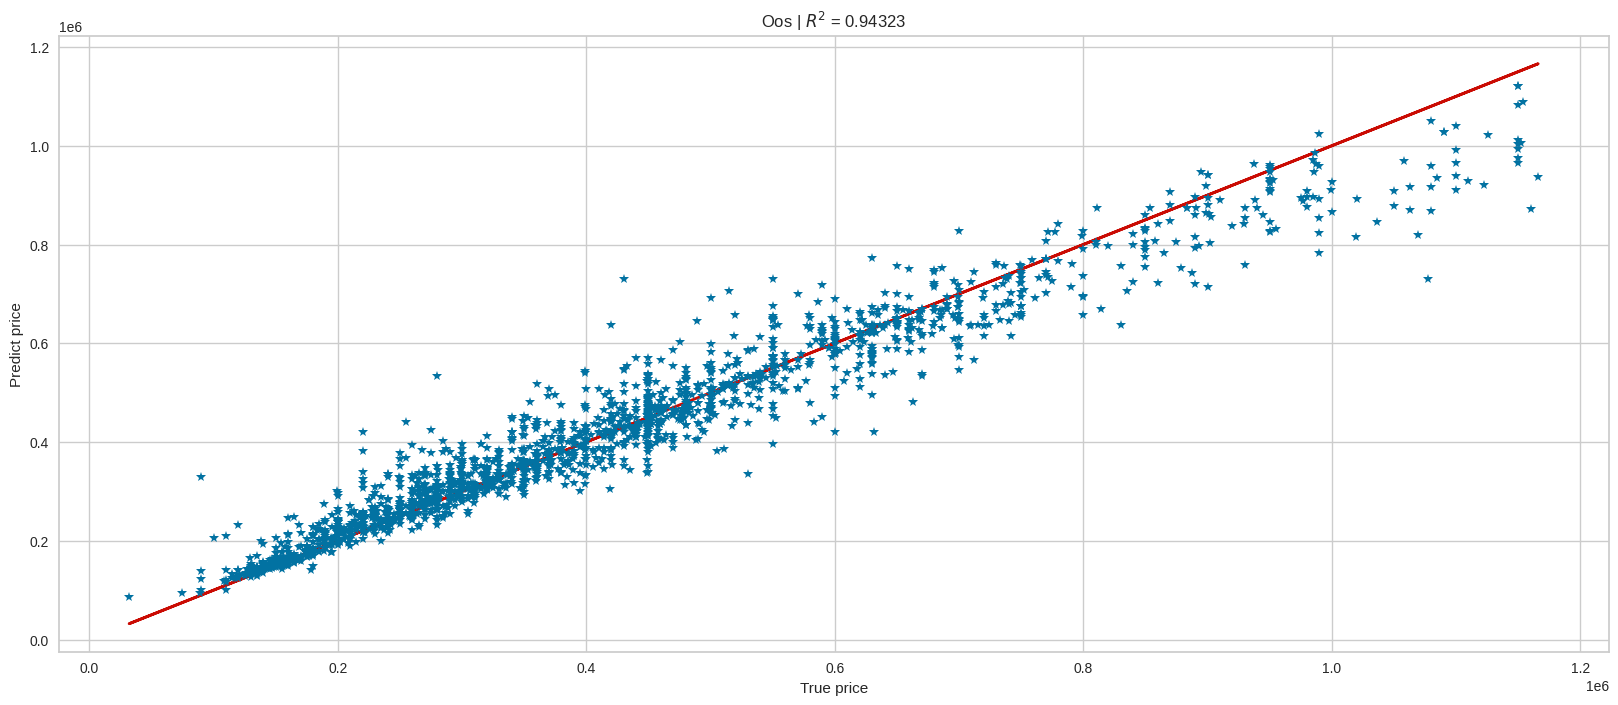

In [108]:
fig_oos_true_pred = plot_true_vs_pred_multiple(
    data_values,
    metrics_results,
    target,
    linewidth = 2
    #linestyle='dashed'
)

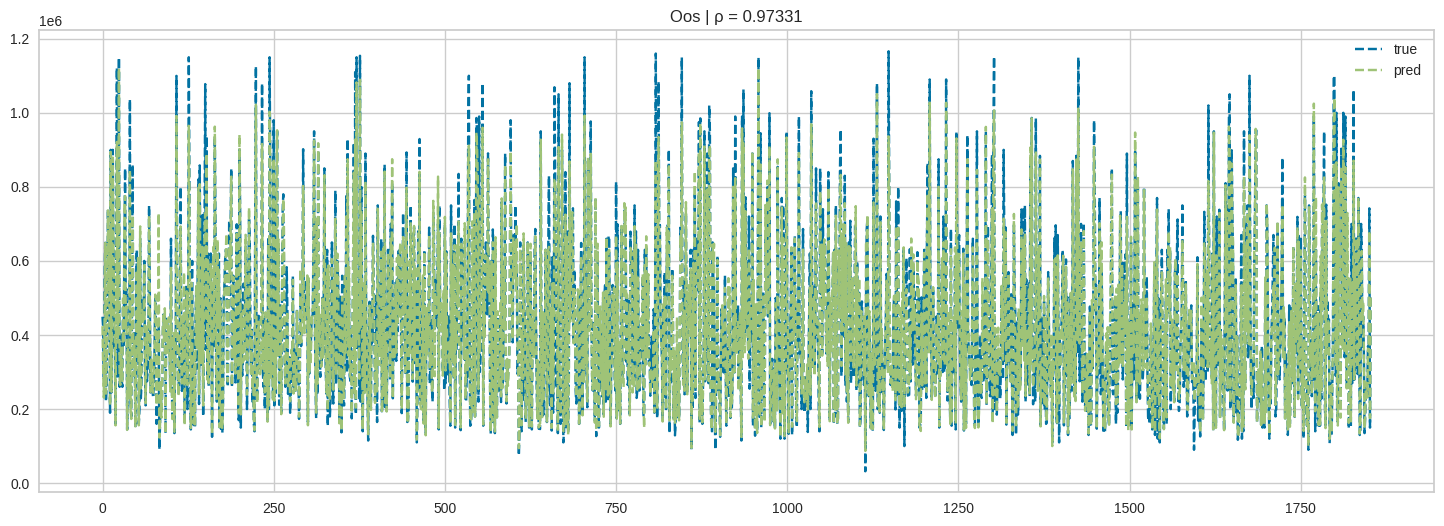

In [109]:
fig_true_vs_pred = plot_true_vs_pred(
    data_values,
    None,
    None,
    figsize = (18, 6),
    linestyle = 'dashed'
)